In [1]:
# default_exp data

# DICOM preprocessing methods

> ...

In [26]:
from nbdev import *

In [28]:
# export

import os
import random
from scipy.ndimage import zoom
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [2]:
# export
from lunglens.core import *
from lunglens.core import DEV_CONFIG as cfg

In [3]:
ds_dir = Path('../data/extracted/osic-pulmonary-fibrosis-progression')
all_files = list(ds_dir.rglob('ID0*'))
# random_img = random.choice(all_files)
random_img = '../data/extracted/osic-pulmonary-fibrosis-progression/train/ID00388637202301028491611'

### DICOM reading

In [4]:
# export
def read_dicom_folder(folder):
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(reader.GetGDCMSeriesFileNames(str(folder)))

    itk_image = reader.Execute()
    image = sitk.GetArrayFromImage(itk_image)
    
    return image, itk_image

In [5]:
# export
def read_dicom_file(file_path):
    itk_image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(itk_image)
    
    return image, itk_image

In [6]:
data, itk_image = read_dicom_folder(random_img)

data.min(), data.mean(), data.max(), data.shape

(-1024, -651.621695561225, 3455, (429, 768, 768))

In [7]:
# export
def rescale_dicom(itk_image, image, target_voxel_mm, order=2):
    spacing_xyz = itk_image.GetSpacing()
    spacing_zyx = np.flip(spacing_xyz)
    
    resize_ratio = spacing_zyx / target_voxel_mm
    
    return zoom(image, resize_ratio, order=order)

In [8]:
img_resized = rescale_dicom(itk_image, data, cfg.TARGET_MM_PER_VX)
img_resized.shape

(300, 400, 400)

### Visualizing

In [9]:
# export
def print_slice(data, cmap='gray', figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=cmap)
    plt.axis('off');

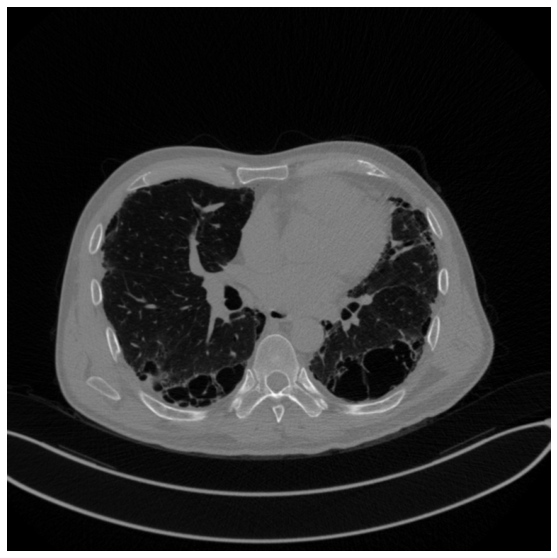

In [10]:
print_slice(data[200])

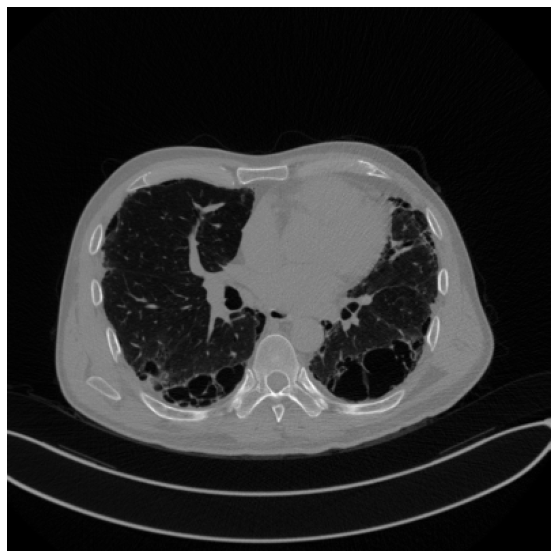

In [11]:
print_slice(img_resized[140])

In [12]:
# export
def print_hist(data, bins=50):
    plt.hist(data.flatten(), bins=bins)

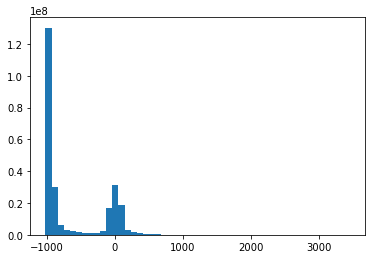

In [13]:
print_hist(data)

### Preprocessing

In [14]:
# export

# lung CT window info
window_w = 1500
window_l = -600

def appply_window(data, l=window_l, w=window_w, normalize=False):
    min_value = l - w / 2
    max_value = l + w / 2
    
    data = np.clip(data, min_value, max_value)
    
    if normalize:
        data = (data - min_value) / w
    
    return data

In [15]:
# windowed data
w_data = appply_window(data)

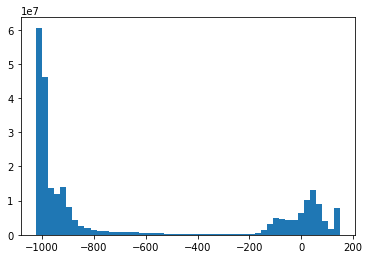

In [16]:
print_hist(w_data)

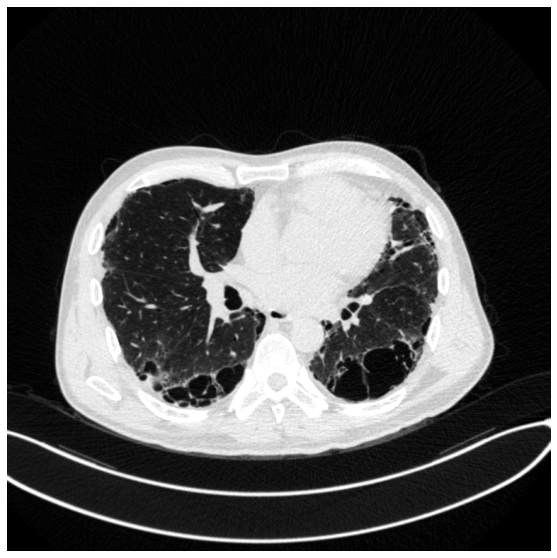

In [17]:
print_slice(w_data[200])

In [18]:
# windowed normalized data
wn_data = appply_window(data, normalize=True)

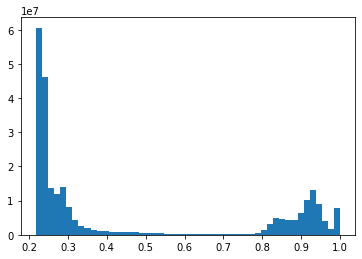

In [19]:
print_hist(wn_data)

In [20]:
# export
def convert_dicoms2np(dicoms, dest_dir, target_voxel_mm=cfg.TARGET_MM_PER_VX):
    for scan_f in tqdm(dicoms):
        scan_id = scan_f.stem if scan_f.is_file() else scan_f.name
        result_folder = dest_dir/f'{scan_id}'

#         if result_folder.exists():
#             continue

        try:
            # read dicom with default scaling
            reader = read_dicom_file if scan_f.is_file() else read_dicom_folder
            data, itk_image = reader(scan_f)

            # apply CT window for Lungs
            data = appply_window(data, normalize=True)
            
            # rescale to 1 mm per 1 vx
            data = rescale_dicom(itk_image, data, target_voxel_mm)
            
            os.makedirs(result_folder, exist_ok=True)
            
            # save each slice as numpy
            for slice_i, slice_data in enumerate(data):
                np.save(str(result_folder/f'{slice_i}.npy'), slice_data)
        except Exception as ex:
            print(f'error occured when trying to save scan: {scan_f}')
            print(ex)

In [35]:
few_test_scans = random.sample(all_files, 3)
dest_root_dir = Path('../data/temp')

In [36]:
convert_dicoms2np(few_test_scans, dest_root_dir)

### Looking at data

In [37]:
all_slices = list(dest_root_dir.rglob('*.npy'))
len(all_slices)

915

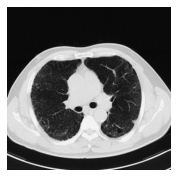

In [64]:
random_img_path = random.choice(all_slices)
random_img_path = '../data/temp/ID00305637202281772703145/193.npy'
random_img = np.load(str(random_img_path))

print_slice(random_img, figsize=(3,3))